In [1]:
import os
import SimpleITK as sitk
import numpy as np
import radiomics
import matplotlib.pyplot as plt
from skimage import io as skio
from skimage.color import rgb2gray
import cv2
import pandas as pd
from skimage import img_as_ubyte
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [2]:
from radiomics import featureextractor, getFeatureClasses
from radiomics import glcm

In [3]:
cwd = os.getcwd()

In [4]:
im = skio.imread('textured-triangle.png')
im = rgb2gray(im)
im = img_as_ubyte(im)

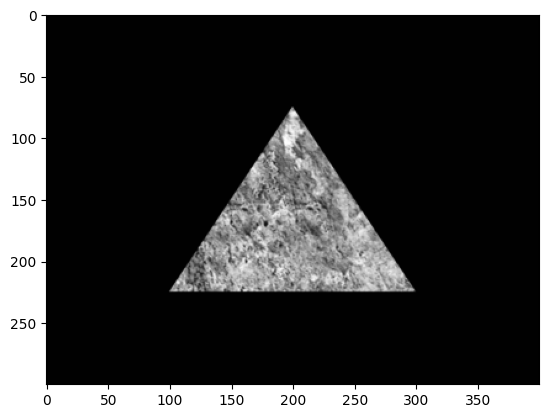

In [5]:
plt.imshow(im, cmap="gray")

In [6]:
#croping image:
n, p = im.shape

# Si la hauteur est plus grande que la largeur, recadrez en carré
if n > p:
    diff = (n - p) // 2
    im = im[diff:diff + p, :]
# Si la largeur est plus grande que la hauteur, recadrez en carré
elif p > n:
    diff = (p - n) // 2
    im = im[:, diff:diff + n]

# Maintenant, im est une image carrée
n, p = im.shape
n,  p

(300, 300)

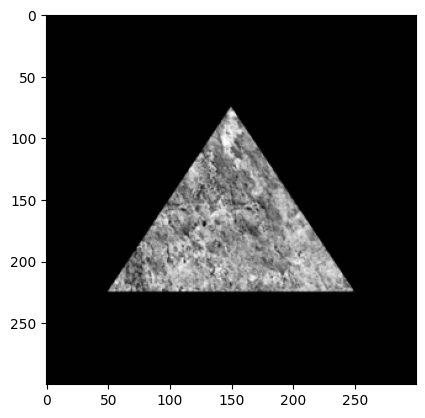

In [7]:
plt.imshow(im, cmap='gray')

In [8]:
#creation du mask

def mask(h, l, side_length):
    image = np.zeros((h, l), dtype=np.uint8)
    half_side = side_length / 2
    x1 = int((l - side_length) / 2)
    x2 = int((l + side_length) / 2)
    y1 = int((h + (side_length * np.sqrt(3) / 2)) / 2)
    y2 = int((h + (side_length * np.sqrt(3) / 2)) / 2 - side_length * np.sqrt(3) / 2)

    pts = np.array([[x1, y1], [x2, y1], [l // 2, y2]], np.int32)
    pts = pts.reshape((-1, 1, 2))
    cv2.fillPoly(image, [pts], 1)

    return image

Text(0.5, 1.0, 'mask')

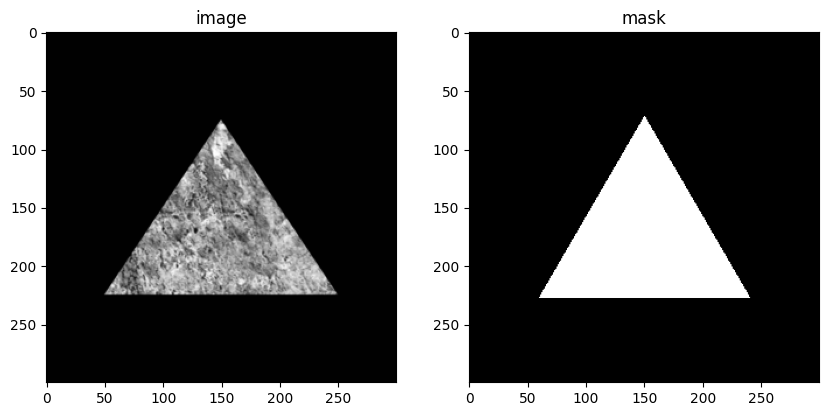

In [9]:
plt.figure(figsize=(10,10))
# First image
plt.subplot(2,2,1)
plt.imshow(im, cmap = 'gray')
plt.title("image")
plt.subplot(2,2,2)
plt.imshow(mask(300, 300, 180), cmap = 'gray')
plt.title("mask")

In [10]:
# Transform image and mask to format
im_ITK, mask_ITK  = sitk.GetImageFromArray(im), sitk.GetImageFromArray(mask(300, 300, 180))

In [11]:
extractor=featureextractor.RadiomicsFeatureExtractor()
extractor.enableFeaturesByName()

In [12]:
featuresVector = extractor.execute(im_ITK, mask_ITK)
numeric_features = {}

# Liste des noms de caractéristiques (clefs du dictionnaire) à partir de l'indice 24
feature_names = list(featuresVector.keys())[24:]

# Itérez à travers la liste des noms de caractéristiques
for feature_name in feature_names:
    feature_value = featuresVector[feature_name]
    numeric_features[feature_name] = feature_value


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


In [13]:
#compute only GLCM features
# la matrice de co-occurrence des niveaux de gris (GLCM)
glcmFeatures = glcm.RadiomicsGLCM(im_ITK, mask_ITK)
glcmFeatures.enableAllFeatures()
result = glcmFeatures.execute()

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


In [14]:
features = np.array(list(result.values()))
args = list(result.keys())

In [15]:
args

['Autocorrelation',
 'ClusterProminence',
 'ClusterShade',
 'ClusterTendency',
 'Contrast',
 'Correlation',
 'DifferenceAverage',
 'DifferenceEntropy',
 'DifferenceVariance',
 'Id',
 'Idm',
 'Idmn',
 'Idn',
 'Imc1',
 'Imc2',
 'InverseVariance',
 'JointAverage',
 'JointEnergy',
 'JointEntropy',
 'MCC',
 'MaximumProbability',
 'SumAverage',
 'SumEntropy',
 'SumSquares']

In [16]:
df=pd.DataFrame({"feature":args, "value": features})

In [17]:
df

,feature,value
0,Autocorrelation,20.712846
1,ClusterProminence,99.002797
2,ClusterShade,-8.457622
3,ClusterTendency,4.765176
4,Contrast,0.734853
5,Correlation,0.731905
6,DifferenceAverage,0.536619
7,DifferenceEntropy,1.295382
8,DifferenceVariance,0.441218
9,Id,0.758738


In [18]:
#Elementary transformations :
def rotate_image(image, theta):
    # Get the center of the image
    height, width = image.shape[:2]
    center = (width / 2, height / 2)

    # Define a rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, theta, 1.0)

    # Apply the rotation to the image
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))

    return rotated_image

In [19]:
def Get_values_without_error(im,XX,YY):
    """ retouren une image de la taille de XX et YY 
     qui vaut im[XX,YY] mais en faisant attention a ce que XX et YY ne debordent
     pas """
    sh=XX.shape
    defaultval=0;
    if len(im.shape)>2: #color image !
        defaultval=np.asarray([0,0,0])
        sh=[*sh,im.shape[2]]
    imout=np.zeros(sh)
    (ty,tx)=XX.shape[0:2]
    for k in range(ty):
        for l in range(tx):
            posx=int(XX[k,l]-0.5)
            posy=int(YY[k,l]-0.5)
            if posx<0 or posx>=im.shape[1] or posy<0 or posy>=im.shape[0]:
                valtmp=defaultval
            else:
                valtmp=im[posy,posx]
            imout[k,l]=valtmp
    
    return imout 
def rotation(im,theta,alpha=1.0,x0=None,y0=None,ech=0,clip=True):
    dy=im.shape[0]
    dx=im.shape[1]
    
    if x0 is None:
        x0=dx/2.0
    if y0 is None:
        y0=dy/2.0
    v0=np.asarray([x0,y0]).reshape((2,1))
    theta=theta/180*np.pi
    ct=alpha*np.cos(theta)
    st=alpha*np.sin(theta)
    matdirect=np.asarray([[ct,-st],[st,ct]])
    if clip==False:
        #ON CALCULE exactement la transformee des positions de l'image
        # on cree un tableau des quatre points extremes
        tabextreme=np.asarray([[0,0,dx,dx],[0,dy,0,dy]])
        tabextreme_trans= matdirect@(tabextreme-v0)+v0
        xmin=np.floor(tabextreme_trans[0].min())
        xmax=np.ceil(tabextreme_trans[0].max())
        ymin=np.floor(tabextreme_trans[1].min())
        ymax=np.ceil(tabextreme_trans[1].max())
        
    else:
        xmin=0
        xmax=dx
        ymin=0
        ymax=dy
    if len(im.shape)>2:
        shout=(int(ymax-ymin),int(xmax-xmin),im.shape[2]) # image couleur
    else:
        shout=(int(ymax-ymin),int(xmax-xmin))
    dyout=shout[0]
    dxout=shout[1]
    eps=0.0001
    Xout=np.arange(xmin+0.5,xmax-0.5+eps)
    Xout=np.ones((dyout,1))@Xout.reshape((1,-1)) 
    
    Yout=np.arange(ymin+0.5,ymax-0.5+eps)
    Yout=Yout.reshape((-1,1))@np.ones((1,dxout))
    
    XY=np.concatenate((Xout.reshape((1,-1)),Yout.reshape((1,-1))),axis=0)
    XY=np.linalg.inv(matdirect)@(XY-v0)+v0
    Xout=XY[0,:].reshape(shout)
    Yout=XY[1,:].reshape(shout)
    if ech==0: # plus proche voisin
        out=Get_values_without_error(im,Xout,Yout)
    else:  #bilineaire 
        assert ech == 1 , "Vous avez choisi un echantillonnage inconnu"
        Y0=np.floor(Yout-0.5)+0.5 # on va au entier+0.5 inferieur
        X0=np.floor(Xout-0.5)+0.5
        Y1=np.ceil(Yout-0.5)+0.5
        X1=np.ceil(Xout-0.5)+0.5
        PoidsX=Xout-X0
        PoidsY=Yout-Y0
        PoidsX[X0==X1]=1 #points entiers
        PoidsY[Y0==Y1]=1 #points entiers
        I00=Get_values_without_error(im,X0,Y0)
        I01=Get_values_without_error(im,X0,Y1)
        I10=Get_values_without_error(im,X1,Y0)
        I11=Get_values_without_error(im,X1,Y1)
        out=I00*(1.0-PoidsX)*(1.0-PoidsY)+I01*(1-PoidsX)*PoidsY+I10*PoidsX*(1-PoidsY)+I11*PoidsX*PoidsY
    return out



In [20]:
#To facilitate, we will define a function that returns the dataframe of the GLCMfeatures of an image and mask passed in argument 

def glcmFeatures(image, mask):
    im_ITK, mask_ITK  = sitk.GetImageFromArray(image), sitk.GetImageFromArray(mask)
    glcmFeatures = glcm.RadiomicsGLCM(im_ITK, mask_ITK)
    glcmFeatures.enableAllFeatures()
    result = glcmFeatures.execute()

    features = np.array(list(result.values()))
    args = list(result.keys())
    df=pd.DataFrame({"feature":args, "value": features})
    return df


In [21]:


# List of DataFrames, one for each rotation angle
dataframes1 = []  
for theta in range(360):
    df_theta = glcmFeatures(rotation(im, theta), rotation(mask(300, 300, 180), theta))
    dataframes1.append(df_theta)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

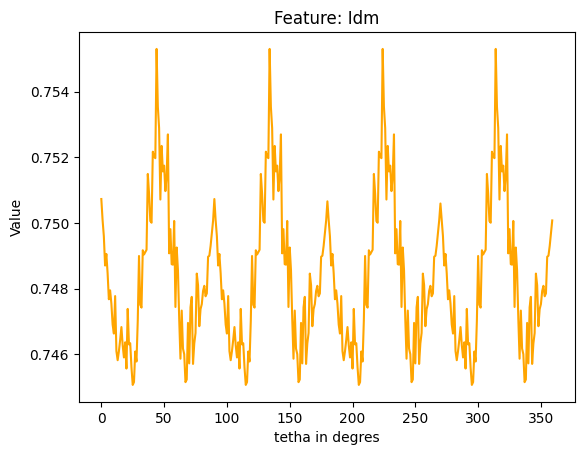

In [22]:
def plot_feature(featurew, dataframes):
    feature_values = [df[dataframes[0].feature==featurew].value.iloc[0] for df in dataframes]
    
    plt.plot(range(360), feature_values, color="orange")
    plt.title(f'Feature: {featurew}')
    plt.xlabel('tetha in degres')
    plt.ylabel('Value')

plot_feature("Idm", dataframes=dataframes1)

In [23]:
dataframes1[0][dataframes1[0].feature=="Idm"].value.iloc[0]

0.7507300840762605

In [24]:
def plot_features(dataframes, features, figure_size=(5, 3)):
    num_features = len(features)
    num_dataframes = len(dataframes)

    fig, axes = plt.subplots(num_features, 1, figsize=(figure_size[0], figure_size[1] * num_features))

    for i, featurew in enumerate(features):
        ax = axes[i]
        feature_values = [df[dataframes[0].feature==featurew].value.iloc[0] for df in dataframes]
        feature_values= scaler.fit_transform(np.array(feature_values).reshape(-1, 1))
        ax.plot(range(num_dataframes), feature_values, color="blue")
        ax.set_title(f'Feature:' + featurew)
        ax.set_xlabel('tetha in degres')
        ax.set_ylabel('Value')
    plt.tight_layout()
    plt.show()

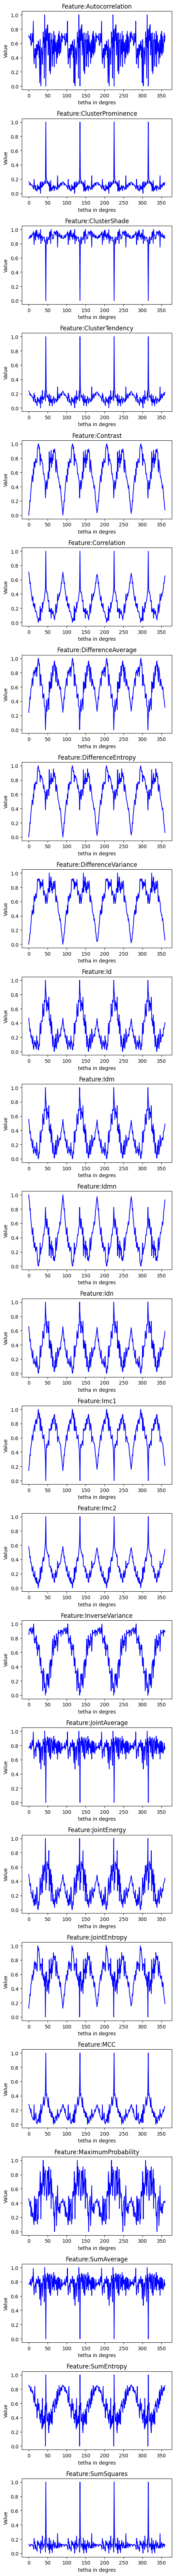

In [25]:
features_all = dataframes1[0].feature.tolist()
plot_features(dataframes=dataframes1, features=features_all)

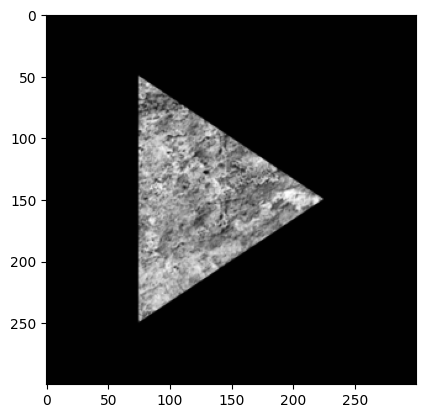

In [26]:
plt.imshow(rotation(im, 90), cmap="gray")

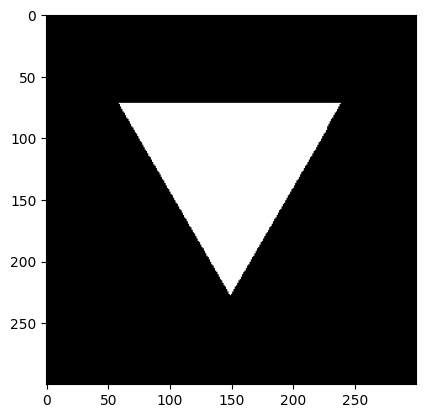

In [27]:
plt.imshow(rotation(mask(300, 300, 180), 180), cmap="gray")

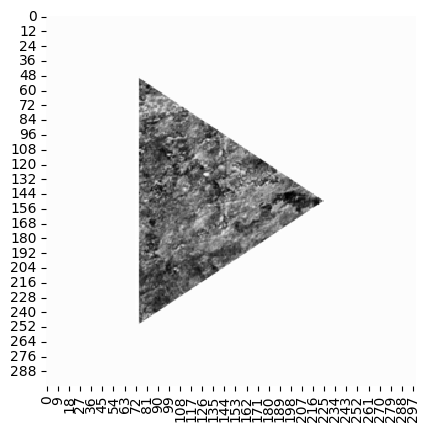

In [28]:
plt.imshow(rotation(mask(300, 300, 180), 90)- rotation(im, 90), cmap="gray")
sns.heatmap(rotation(mask(300, 300, 180), 90)- rotation(im, 90), cmap="gray", cbar=False)
plt.axis('on')  # Hide the axis
plt.show()

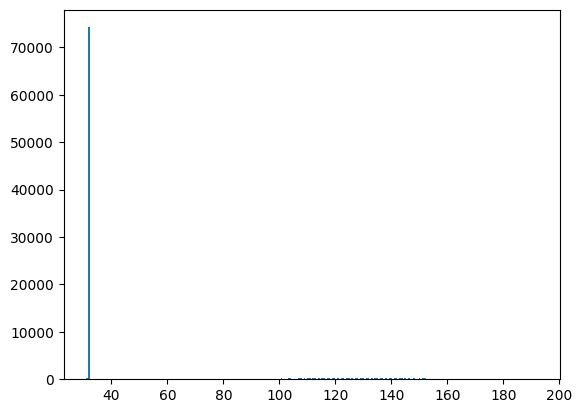

In [29]:
plt.hist(im.reshape((-1,)),bins=255)
plt.show()

**stabilité par rapport au bruit**

In [30]:
def noise(im,br):
    """ Cette fonction ajoute un bruit blanc gaussier d'ecart type br
       a l'image im et renvoie le resultat"""
    imt=np.float32(im.copy())
    sh=imt.shape
    bruit=br*np.random.randn(*sh)
    imt=imt+bruit
    return imt

# List of DataFrames, one for strd value
dataframes = []  
for sigma in np.linspace(1, 20, 300):
    df_sigma = glcmFeatures(noise(im, sigma), mask(300, 300, 180))
    dataframes.append(df_sigma)

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

In [31]:
def plot_features(dataframes, features, figure_size=(5, 3)):
    num_features = len(features)
    num_dataframes = len(dataframes)

    fig, axes = plt.subplots(num_features, 1, figsize=(figure_size[0], figure_size[1] * num_features))

    for i, featurew in enumerate(features):
        ax = axes[i]
        feature_values = [df[dataframes[0].feature==featurew].value.iloc[0] for df in dataframes]
        feature_values= scaler.fit_transform(np.array(feature_values).reshape(-1, 1))
    
        ax.plot(range(num_dataframes), feature_values, color="magenta")
        ax.set_title(f'Feature:' + featurew)
        ax.set_xlabel('standard deviation of the noise')
        ax.set_ylabel('Value')
    plt.tight_layout()
    plt.show()

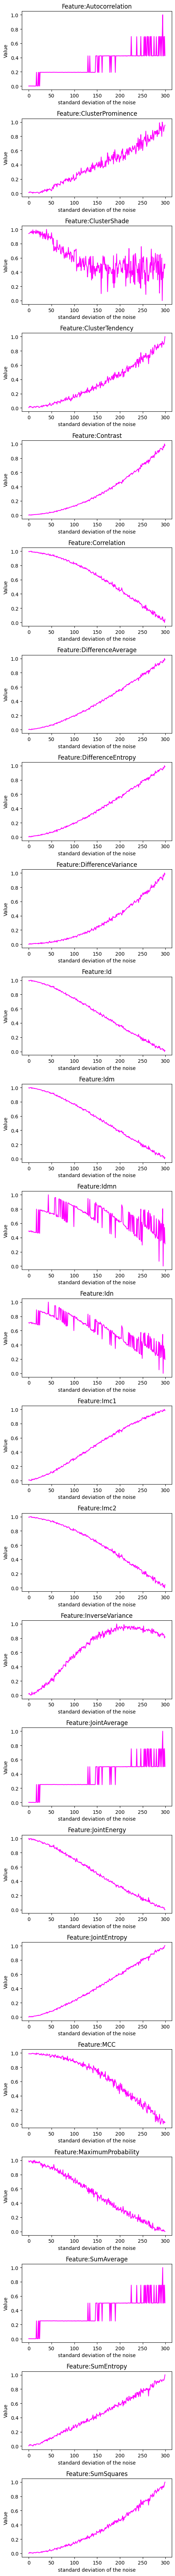

In [32]:
features_all = dataframes[0].feature.tolist()
plot_features(dataframes=dataframes, features=features_all)

**Stabilité par rapport au flou**

In [33]:
def get_gau_ker(s):
    ss=int(max(3,2*np.round(2.5*s)+1))
    ms=(ss-1)//2
    X=np.arange(-ms,ms+0.99)
    y=np.exp(-X**2/2/s**2)
    out=y.reshape((ss,1))@y.reshape((1,ss))
    out=out/out.sum()
    return out
def flou(im,mask):
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    (y,x)=im.shape
    (ym,xm)=mask.shape
    mm=np.zeros((y,x))
    mm[:ym,:xm]=mask
    fout=(fft2(im)*fft2(mm))
    # on fait une translation pour ne pas avoir de decalage de l'image
    # pour un mask de taille impair ce sera parfait, sinon, il y a toujours un decalage de 1/2
    mm[:ym,:xm]=0
    y2=int(np.round(ym/2-0.5))
    x2=int(np.round(xm/2-0.5))
    mm[y2,x2]=1
    out=np.real(ifft2(fout*np.conj(fft2(mm))))
    return out

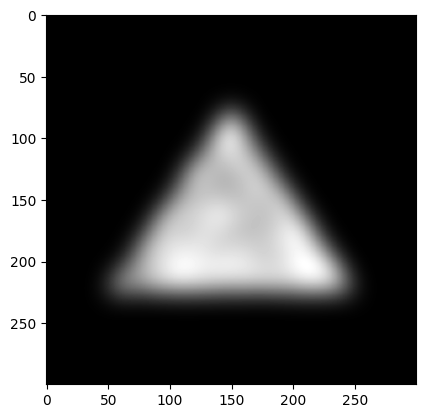

In [34]:
plt.imshow(flou(im, get_gau_ker(10)), cmap="gray")

In [35]:
# List of DataFrames, one for strd value
dataframes2 = []  
for s in np.linspace(1, 10, 300):
    df_flou = glcmFeatures(flou(im, get_gau_ker(s)), mask(300, 300, 180))
    dataframes2.append(df_flou)

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

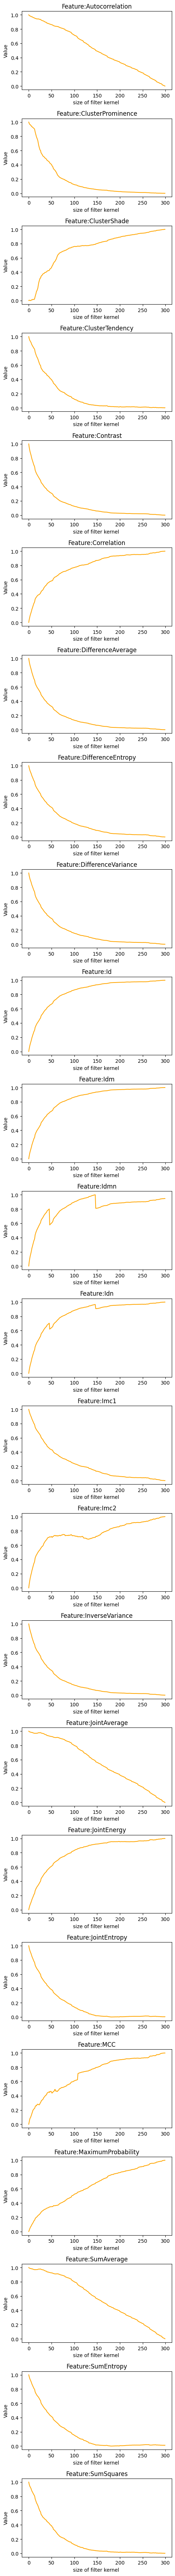

In [36]:
def plot_features(dataframes, features, figure_size=(5, 3)):
    num_features = len(features)
    num_dataframes = len(dataframes)

    fig, axes = plt.subplots(num_features, 1, figsize=(figure_size[0], figure_size[1] * num_features))

    for i, featurew in enumerate(features):
        ax = axes[i]
        feature_values = [df[dataframes[0].feature==featurew].value.iloc[0] for df in dataframes]
        feature_values= scaler.fit_transform(np.array(feature_values).reshape(-1, 1))
    
        ax.plot(range(num_dataframes), feature_values, color="orange")
        ax.set_title(f'Feature:' + featurew)
        ax.set_xlabel('size of filter kernel ')
        ax.set_ylabel('Value')
    plt.tight_layout()
    plt.show()

features_all = dataframes2[0].feature.tolist()
plot_features(dataframes=dataframes2, features=features_all)

**Stability face to contrast change**

In [37]:
# List of DataFrames, one for strd value
dataframes3 = []  
for contrast_factor in np.linspace(1, 10, 300):
    adjusted_image_array = (im - 128) * contrast_factor + 128
    adjusted_image_array = np.clip(adjusted_image_array, 0, 255)  # Clip les valeurs entre 0 et 255
    df_contraste = glcmFeatures(adjusted_image_array, mask(300, 300, 180))
    dataframes3.append(df_contraste)

adjusted_image_array = (im - 128) * contrast_factor + 128
adjusted_image_array = np.clip(adjusted_image_array, 0, 255)  # Clip les valeurs entre 0 et 255


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

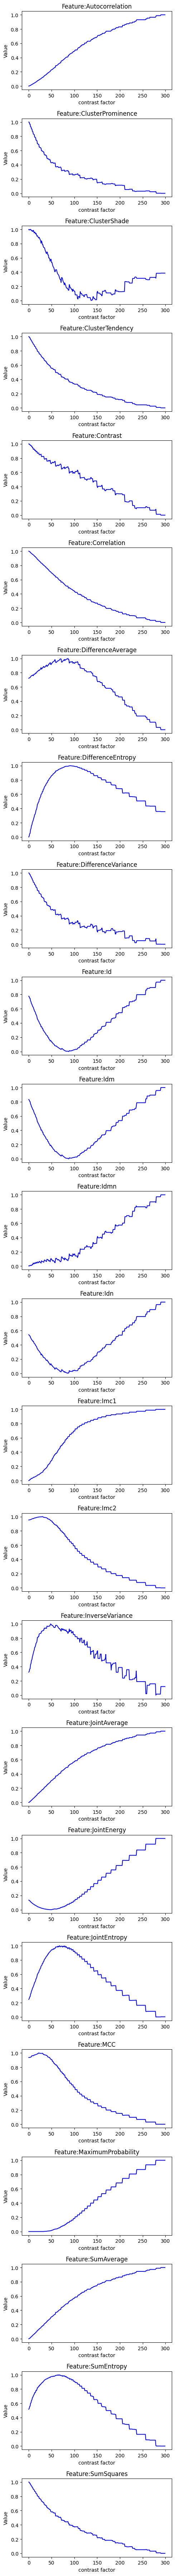

In [39]:
def plot_features(dataframes, features, figure_size=(5, 3)):
    num_features = len(features)
    num_dataframes = len(dataframes)

    fig, axes = plt.subplots(num_features, 1, figsize=(figure_size[0], figure_size[1] * num_features))

    for i, featurew in enumerate(features):
        ax = axes[i]
        feature_values = [df[dataframes[0].feature==featurew].value.iloc[0] for df in dataframes]
        feature_values= scaler.fit_transform(np.array(feature_values).reshape(-1, 1))
    
        ax.plot(range(num_dataframes), feature_values, color="blue")
        ax.set_title(f'Feature:' + featurew)
        ax.set_xlabel('contrast factor')
        ax.set_ylabel('Value')
    plt.tight_layout()
    plt.show()

features_all = dataframes3[0].feature.tolist()
plot_features(dataframes=dataframes3, features=features_all)

In [40]:
import os
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from tqdm import tqdm
from warnings import warn

def get_jpegs(export_path: str, data_type: str):
    '''Convert each slice of nnrd containing ROI to JPEG image. Quick and convenient way to check your ROIs after conversion.

    Arguments:
        export_path: Path to the folder where the JPEGs will be generated.
        data_type: Type of data, e.g., 'nrrd'.
    '''
    if data_type == 'nrrd':
        # Loop through patients and process data
        for pat, path in tqdm(desc='Patients processed'):
            try:
                temp_data = sitk.ReadImage(path[0])
                temp_mask = sitk.ReadImage(path[1])
                temp_image_array = sitk.GetArrayFromImage(temp_data)
                temp_mask_array = sitk.GetArrayFromImage(temp_mask)

                directory = os.path.join(export_path, 'images_quick_check', pat, path[1][:-5].split(os.sep)[-1])
                z_dist = np.sum(temp_mask_array, axis=(1, 2))
                z_ind = np.where(z_dist != 0)[0]

                for j in z_ind:
                    if not os.path.exists(directory):
                        os.makedirs(directory)
                    temp_image_array[j, 0, 0] = 1
                    temp_mask_array[j, 0, 0] = 1
                    plt.figure(figsize=(20, 20))
                    plt.subplot(121)
                    plt.imshow(temp_image_array[j, ...], cmap='bone')
                    plt.subplot(122)
                    plt.imshow(temp_image_array[j, ...], cmap='bone')
                    plt.contour(temp_mask_array[j, ...], colors='red', linewidths=2)
                    plt.savefig(os.path.join(directory, 'slice #%d' % j), bbox_inches='tight')
                    plt.close()
            except Exception:
                warn('Something wrong with %s' % pat)
    else:
        raise TypeError('The toolbox should be initialized with data_type = "nrrd"')

    

In [ ]:
def extract_features(self, params_file: str, loggenabled: bool =False) -> DataFrame:
        """Extract PyRadiomic features from the dataset.

                Arguments:
                    params_file: File with the PyRadiomics parameters for features extraction.
                    loggenabled: Enable/disable log file writing.

                Returns:
                    DataFrame with the extracted features.
        """

        if self._data_type =='nrrd':
            #set up pyradiomics
            if loggenabled:
                logger = radiomics.logger
                logger.setLevel(logging.DEBUG)  # set level to DEBUG to include debug log messages in log file

                # Write out all log entries to a file
                handler = logging.FileHandler(filename='test_log.txt', mode='w')
                formatter = logging.Formatter("%(levelname)s:%(name)s: %(message)s")
                handler.setFormatter(formatter)
                logger.addHandler(handler)

            # Initialize feature extractor using the settings file
            feat_dictionary,key_number={},0
            extractor = featureextractor.RadiomicsFeatureExtractor(params_file)

            for pat,path in tqdm(self,desc='Patients processed'):
                try:
                    temp_data = sitk.ReadImage(path[0])
                    temp_mask = sitk.ReadImage(path[1])
                    pat_features = extractor.execute(temp_data, temp_mask)

                    if pat_features['diagnostics_Image-original_Hash'] != '':
                        pat_features.update({'Patient':pat,'ROI':path[1].split(os.sep)[-1][:-5]})
                        feat_dictionary[key_number] = pat_features
                        key_number+=1

                except KeyboardInterrupt:
                    raise
                except Exception:
                    warn('region : %s skipped'%pat)

            output_features = DataFrame.from_dict(feat_dictionary).T

            return output_features
        else:
            raise TypeError('The toolbox should be initialized with data_type = "nrrd"')